In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import pprint
import matplotlib.pyplot as plt
import sys
import pickle
import argparse
import logging
import os

from ginkgo import invMass_ginkgo
from ginkgo.utils import get_logger


logger = get_logger(level=logging.WARNING)


In [6]:
"""Parameters"""


rate2=torch.tensor(8.)

# Parameters to get ~<10 constituents to test the trellis algorithm
pt_min = torch.tensor(4.**2)
# pt_min = torch.tensor(2.3**2)

# pt_min = torch.tensor(1.1**2) # For leaves between 5 and 40

# pt_min = torch.tensor(0.02**2)

### Physics inspired parameters to get ~ between 20 and 50 constituents
W_rate = 3.
QCD_rate = 1.5
# pt_min = torch.tensor(1.2**2)

QCD_mass = 30.
class ginkgo_simulator():
    def __init__(self,
                 rate,
                 pt_cut,
                 M2start,
                 Nsamples,
                 minLeaves,
                 maxLeaves,
                 maxNTry,
                 jetType, 
                 jetP,
                 root_rate= 1.5,
                ):
        
        self.root_rate = root_rate
        self.rate = rate
        self.pt_cut = pt_cut
        self.M2start=torch.tensor(M2start)
        self.Nsamples=Nsamples
        self.minLeaves=minLeaves
        self.maxLeaves=maxLeaves
        self.maxNTry=maxNTry
        self.jetType= jetType
        self.jetM = np.sqrt(M2start)
        self.jetdir = np.array([1,1,1])
        self.jetP = jetP
        self.jetvec = self.jetP * self.jetdir / np.linalg.norm(self.jetdir)
        self.jet4vec = np.concatenate(([np.sqrt(self.jetP**2 + self.jetM**2)], self.jetvec))
        logger.debug(f"jet4vec = {self.jet4vec}")
        
        if jetType == "W":
            """ W jets"""
            self.rate=torch.tensor([self.root_rate,self.rate]) #Entries: [root node, every other node] decaying rates. Choose same values for a QCD jet
        elif jetType == "QCD":
            """ QCD jets """
            self.rate=torch.tensor([self.rate,self.rate]) #Entries: [root node, every other node] decaying rates. Choose same values for a QCD jet
        else:
            raise ValueError("Choose a valid jet type between W or QCD")



    def simulator(self):

        simulator = invMass_ginkgo.Simulator(jet_p=self.jet4vec,
                                         pt_cut=float(self.pt_cut),
                                         Delta_0=self.M2start,
                                         M_hard=self.jetM ,
                                         num_samples=int(self.Nsamples),
                                         minLeaves =int(self.minLeaves),
                                         maxLeaves = int(self.maxLeaves),
                                         maxNTry = int(self.maxNTry)
                                         )
        return simulator
       
    def generate(self):
        
        simulator = self.simulator()
        jet_list = simulator(self.rate)

        logger.debug(f"---"*10)
        logger.debug(f"jet_list = {jet_list}")
        
        return jet_list

In [84]:
minLeaves = 3
maxLeaves = 100
Nsamples = 2000

rate = 1.5
pt_cut =  torch.tensor(1.1**2)
M2start = 80.**2
maxNTry = 20000
jetP=400.

In [85]:
jetType ="QCD"


ginkgo= ginkgo_simulator(
                 rate,
                 pt_cut ,
                 M2start,
                 Nsamples,
                 minLeaves,
                 maxLeaves,
                 maxNTry,
                 jetType, 
                 jetP)

QCD_jets = ginkgo.generate()

------------------------------
------------------------------
Generated  1000 jets with  3 <=number of leaves< 100
Generated  1000  jets
------------------------------
Generated  2000 jets with  3 <=number of leaves< 100
Generated  2000  jets


In [107]:
root_rate = 4.
jetType ="W"


ginkgo= ginkgo_simulator(
                 rate,
                 pt_cut ,
                 M2start,
                 Nsamples,
                 minLeaves,
                 maxLeaves,
                 maxNTry,
                 jetType, 
                 jetP,
                 root_rate)

W_jets = ginkgo.generate()

------------------------------
------------------------------
------------------------------
------------------------------
Generated  1000 jets with  3 <=number of leaves< 100
Generated  1000  jets
Generated  2000 jets with  3 <=number of leaves< 100
Generated  2000  jets


In [108]:
N_QCD = [len(jet["leaves"]) for jet in QCD_jets]
N_W= [len(jet["leaves"]) for jet in W_jets]

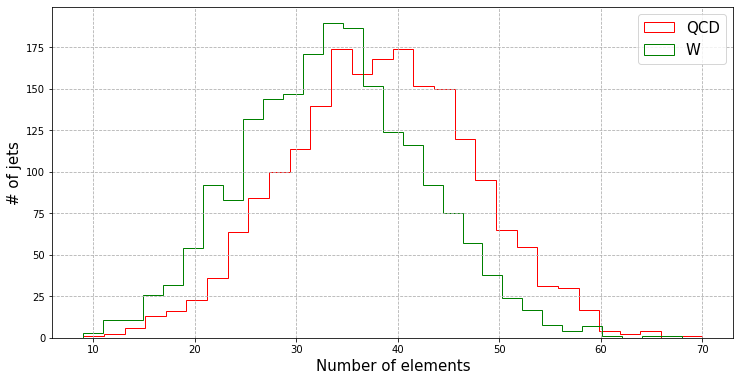

In [115]:
bins=30
fig2, (axes) = plt.subplots(nrows=1, ncols=1)
fig2.set_size_inches(10, 5)
plt.tight_layout(pad=0.4, w_pad=5, h_pad=1.0)
axes.hist(N_QCD,  bins=bins,
                 histtype="step",
                 fill=False,
                 align='mid',
                 label="QCD",
                 color="red")
axes.hist(N_W,  bins=bins,
                 histtype="step",
                 fill=False,
                 align='mid',
                 label="W",
                 color="green")

axes.set_xlabel("Number of elements", fontsize=15)
axes.set_ylabel("# of jets", fontsize=15)

axes.legend(loc='best', fontsize=15)
axes.grid(which='both', axis='both', linestyle='--')

In [110]:
def pTetaPhi(jets):

    for jet in jets:
        p =np.asarray([ np.linalg.norm(const[1::]) for const in  jet["leaves"] ])
        px = np.asarray([const[1] for const in  jet["leaves"] ])
        py = np.asarray([const[2] for const in  jet["leaves"] ])
        pz =np.asarray( [const[3] for const in  jet["leaves"] ])

        pT = np.asarray([ np.linalg.norm(const[1:3]) for const in  jet["leaves"] ])
        eta = 0.5 * (np.log(p + pz) - np.log(p - pz)) 
        phi = np.arctan2(py, px) 

        
        
        pTj=np.sum(pT)
        eta_c=np.sum(pT*eta)/pTj 
        phi_c=np.sum(pT*phi)/pTj 

        jet["eta_c"] = eta_c
        jet ["phi_c"]  = phi_c
        jet["pT"] = pTj
        
        """ Shift to center at [0,0]"""
        eta = eta - eta_c
        phi = phi - phi_c
        
        jet["pTetaPhi"] =  np.asarray([pT,eta,phi])
        
        """Principal axis"""
        tan_theta=0.
        M11=np.sum(jet["pTetaPhi"][0]*jet["pTetaPhi"][1]*jet["pTetaPhi"][2])
        M20=np.sum(jet["pTetaPhi"][0]*jet["pTetaPhi"][1]*jet["pTetaPhi"][1])
        M02=np.sum(jet["pTetaPhi"][0]*jet["pTetaPhi"][2]*jet["pTetaPhi"][2])  
        denom=(M20-M02+np.sqrt(4*M11*M11+(M20-M02)*(M20-M02)))
        if(denom!=0):
            tan_theta=2*M11/denom

#         print("tan(theta) = ", tan_theta)

        """Rotate"""
        rotpt=jet["pTetaPhi"][0]
        roteta=jet["pTetaPhi"][1]*np.cos(np.arctan(tan_theta))+jet["pTetaPhi"][2]*np.sin(np.arctan(tan_theta))
        rotphi=np.unwrap(-jet["pTetaPhi"][1]*np.sin(np.arctan(tan_theta))+jet["pTetaPhi"][2]*np.cos(np.arctan(tan_theta)))
        
        
        jet["rotpTetaPhi"] =  np.asarray([rotpt, roteta, rotphi])


    return jets

In [111]:
def pixelate(DReta,DRphi,npoints , jets):
    etamin, etamax = -DReta, DReta # Eta range for the image
    phimin, phimax = -DRphi, DRphi # Phi range for the image

    allimages=[]
    grid=np.zeros((npoints-1,npoints-1))
    
    for jet in jets:
    
        ietalist =(( jet["rotpTetaPhi"][1]+DReta)/(2*DReta/float(npoints-1))).astype(int)
        iphilist =(( jet["rotpTetaPhi"][2]+DRphi)/(2*DRphi/float(npoints-1))).astype(int)
    
        for ipos in range(len( jet["rotpTetaPhi"][0])):

            if(0 <= ietalist[ipos] < npoints-1 and 0 <= iphilist[ipos] <npoints-1):
                
                grid[ietalist[ipos],iphilist[ipos]]+= [jet["rotpTetaPhi"][0][ipos]] 


    return grid/np.sum(grid)

In [112]:
DReta =0.6
DRphi = 0.6
Npoints = 50

jets_dic={"W":W_jets,"QCD":QCD_jets}

images={}
for key in jets_dic.keys():
    pTetaPhiList = pTetaPhi(jets_dic[key])
    images[key] = pixelate(DReta, DRphi,Npoints, pTetaPhiList)

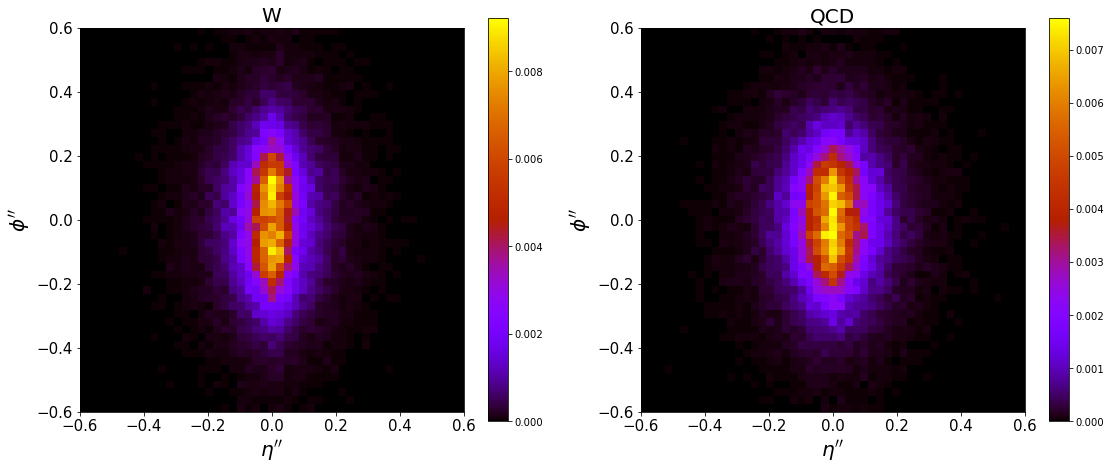

In [113]:
fig2, (axes) = plt.subplots(nrows=1, ncols=2)
fig2.set_size_inches(15,6)
plt.tight_layout(pad=0.4, w_pad=5, h_pad=1.0)

for i,key in enumerate(jets_dic.keys()):
    cl1 = axes[i].imshow(images[key], 'gnuplot', aspect = "equal", extent=[-DReta, DReta,-DRphi, DRphi])# , 
#     cl1 = axes[i].imshow(images[key], 'gnuplot', extent=[-DReta, DReta,-DRphi, DRphi],  norm=LogNorm(vmin=0.01, vmax=1))# , origin='upper', interpolation='none', vmin=0, vmax=0.5)
    axes[i].set_title(r""+str(key), fontsize = 20)
    
#     cbar = fig2.colorbar(cl1)
    fig2.colorbar(cl1, ax=axes[i])
    
    axes[i].set_xlabel('$\eta^{\prime\prime}$', size = 20)
    axes[i].set_ylabel('$\phi^{\prime\prime}$', size =20)
    
#         cl1 = axes.scatter(np.asarray(results["trellis_MLE"]), np.asarray(results["Z"]), c=np.asarray(results["Nleaves"]), marker="X", s=markersize)
# #     axes[i].scatter(truthLogLH, BSO_jetsListLogLH, color='green', marker="o", s=markersize, label="Beam Search")

    
#     cb = fig2.colorbar(cl1, ax=axes, fraction=0.15, shrink=1.0, aspect=20)
#     cb.set_label(label="Number of leaves", size=25)
#     cb.ax.tick_params(labelsize=15)
    

    cl1.axes.tick_params(labelsize=15) 


plt.show()